In [1]:
%load_ext line_profiler
import pyclifford as pc
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import qiskit.quantum_info as qi
import scienceplots
import jax.numpy as jnp
import seaborn as sns
import pickle
import qiskit
import jax
from tqdm.auto import *
import itertools
import pyclifford as pyc
import tensornetwork as tn
import functools as ft
import math
from functools import partial
import optax
import scipy.signal
from labellines import labelLine, labelLines

tn.set_default_backend("jax")

sns.set_theme()
sns.set_style("white")
sns.set_context('paper')
plt.style.use(['science', 'grid'])
mpl.rc('font', family='serif')

In [57]:
with open('./aklt/20231103_noise_error_generator_even.pkl', 'rb') as f:
    noise_even = pickle.load(f)
with open('./aklt/20231103_noise_error_generator_odd.pkl', 'rb') as f:
    noise_odd = pickle.load(f)
noise_even = {k[::-1]: np.real(v) for k, v in dict(noise_even).items()}
noise_odd = {k[::-1]: np.real(v) for k, v in dict(noise_odd).items()}
all_noise_keys = set(noise_odd.keys()).union(set(noise_even.keys()))
noise_even = {k: noise_even[k] if k in noise_even else 0. for k in all_noise_keys}
noise_odd = {k: noise_odd[k] if k in noise_odd else 0 for k in all_noise_keys}
N = len(list(all_noise_keys)[0])

In [58]:
import uncertainties.unumpy as unp
def calc_mean(dat):
    mean = np.mean(dat)
    # var = np.mean(np.var(dat, axis=1, ddof=1)/np.sqrt(dat.shape[1])) + np.var(np.mean(dat, axis=1), ddof=1)/np.sqrt(dat.shape[0])
    var = np.var(np.mean(dat, axis=1), ddof=1) + np.mean(np.var(dat, axis=1, ddof=1))
    return mean, np.sqrt(var/dat.size)

# Calibration

In [309]:
with open('./cluster_18_20231221/20231221_clifford_circ_cluster_18_listd_d_1.pkl', 'rb') as f:
    circs = [x.remove_final_measurements(inplace=False) for x in pickle.load(f)]

with open('./cluster_18_20231221/20231221_result_cali_18_d_1.pkl', 'rb') as f:
    dat = [{k[::-1]: v for k, v in d.items()} for d in pickle.load(f)]

In [60]:
paulis = ['I','X','Y','Z']
tmp = []
cliffs = []
for _ in range(1000):
    cliff = qi.random_clifford(1)    
    cliffs.append(cliff)
    ptm = np.zeros((4,4))
    for i, ch in enumerate(paulis):
        lbl = qi.Pauli(ch).evolve(cliff).to_label()
        j = paulis.index(lbl[-1])
        ptm[i,j] = 1 if len(lbl) == 1 else -1
    tmp.append(ptm)
tmp, idxs = np.unique(np.array(tmp), axis=0, return_index=True)
cliffs = [cliffs[i] for i in idxs]
cliff_to_inv = jnp.array([cliffs.index(x.conjugate().transpose()) for x in cliffs])
cliff_ptm_dict = {tuple(c.to_labels()): ptm for (c, ptm) in zip(cliffs, tmp)}
cliff_ptm_arr = jnp.array(tmp)

def circ_to_cliffs(c, adj=True):
    ret = [[] for _ in range(N)]
    for g in c:
        if isinstance(g.operation, qi.operators.symplectic.clifford.Clifford):
            clf_idx = cliffs.index(g.operation.adjoint() if adj else g.operation)
            site = g.qubits[0].index
            ret[site].append(clf_idx)
    return np.array(ret).T

In [61]:
CNOT_pyc = pyc.stabilizer.CliffordMap(np.array([
    [1,0,1,0],
    [0,1,0,0],
    [0,0,1,0],
    [0,1,0,1]
]), np.zeros(4))

def circ_to_pyc(circ):
    U = pyc.stabilizer.identity_map(N)
    cliff_idxs = circ_to_cliffs(circ)
    offset = 1
    for d in range(len(cliff_idxs)):
        Utmp = pyc.stabilizer.identity_map(N)
        for i in range(N):
            op = cliffs[cliff_idxs[-(d+1),i]] # go backwards
            twirl = pyc.stabilizer.CliffordMap(op.tableau[:,:-1], 2*op.tableau[:,-1])
            mask = np.zeros(N)
            mask[i] = 1
            Utmp.embed(twirl, mask.astype(bool))
        U = U.compose(Utmp)
        
        if d < len(cliff_idxs)-1:
            Utmp = pyc.stabilizer.identity_map(N)
            for i in range(offset, N, 2):
                if i < N-1:
                    mask = np.zeros(N)
                    mask[i:i+2] = 1
                    Utmp.embed(CNOT_pyc, mask.astype(bool))
            offset = 1-offset
            U = U.compose(Utmp)
    return U


def get_shadow(idx, observables):
    U = circ_to_pyc(circs[idx])
    gs = pyc.stabilizer.zero_state(N).gs
    ret = []
    for bitstring in dat[idx].keys():
        count = dat[idx][bitstring]
        bitstring = np.array(list(bitstring)).astype(int)
        state = pyc.stabilizer.StabilizerState(gs=gs, ps=2*np.stack([bitstring, np.zeros(N)]).flatten())
        state = state.transform_by(U)
        ret.extend([state.expect(observables)]*count)
    return np.array(ret)

obs_char = 'Z'
# obs_strings = [''.join(x) for x in itertools.product(['I','Z'], repeat=N)][1:]
obs_strings = [''.join(np.roll([obs_char]+['I']*(N-1),d)) for d in range(N)]
obs_strings += [''.join(np.roll([obs_char]*2+['I']*(N-2),d)) for d in range(N-1)]
obs_strings += [''.join(np.roll([obs_char]*3+['I']*(N-3),d)) for d in range(N-2)]
obs_strings += [''.join(np.roll([obs_char]*4+['I']*(N-4),d)) for d in range(N-3)]

obs = pyc.paulialg.paulis(obs_strings)
calibration_expects = np.array([get_shadow(i, obs) for i in trange(len(circs))])

  0%|          | 0/10000 [00:00<?, ?it/s]

/var/folders/sw/mqhrfvw123bbsf3rnj779gj40000gn/T/ipykernel_22073/484017899.py:24: DeprecationWarning: 'Bit.index' is deprecated since Qiskit Terra 0.17 and will be removed in a future release. Bits may be in more than one register. Use 'QuantumCircuit.find_bit' to find all the containing registers within a circuit, and the index of the bit within the circuit.
  site = g.qubits[0].index


In [62]:
idx_to_p = ['I','X','Y','Z']
noise_gates = []

noise_terms = list(sorted(all_noise_keys))
even_noise_values = jnp.array([noise_even[k] for k in noise_terms])
odd_noise_values = jnp.array([noise_odd[k] for k in noise_terms])
# We do a trick: we absorb all the single qubit noise into the two qubit noise
# This double counts all the single qubit noise (since each site has two, two-qubit noise gates acting on it), so we reduce
# those noise weights by half.
# EXCEPT it does not double count the single qubit noise at the boundaries (i.e., qubits 1 and N), so we leave those as is.
noise_reduction_factor = np.ones(len(noise_terms))/2
for i, term in enumerate(noise_terms):
    if term[0] != 'I' and term[1] == 'I':
        noise_reduction_factor[i] = 1
    if term[-1] != 'I' and term[-2] == 'I':
        noise_reduction_factor[i] = 1
noise_reduction_factor = jnp.array(noise_reduction_factor)

site_pauli_to_terms = jnp.zeros((N-1,4,4,len(noise_terms)))
for site in range(N-1):
    for i in range(4):
        for j in range(4):
            target = ['I']*N
            target[site] = idx_to_p[i]
            target[site+1] = idx_to_p[j]
            target = qi.Pauli(''.join(target))
            non_commuting = []
            for k, pauli in enumerate(noise_terms):
                if set(np.argwhere(np.array(list(pauli)) != 'I').flatten()).issubset({site,site+1}):
                    term = qi.Pauli(pauli)
                    if not target.commutes(term):
                        site_pauli_to_terms = site_pauli_to_terms.at[site,i,j,k].set(1.)
            
diag_v = jax.vmap(jnp.diag)
@jax.jit
def get_noise_gates(noise_values):
    ret = jnp.exp(-2*jnp.sum(site_pauli_to_terms * noise_values * noise_reduction_factor, axis=-1)).reshape((N-1,-1))
    return diag_v(ret).reshape((N-1,4,4,4,4))

In [63]:
TWIRL_GATE = jnp.array([
    [1,0,0,0],
    [0,1/3,1/3,1/3],
    [0,1/3,1/3,1/3],
    [0,1/3,1/3,1/3],
])

gate = np.zeros((4,4,4,4))
tmp = qi.Operator(np.linalg.inv([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]]))
chars = ['I','X','Y','Z']
for i in range(4):
    for j in range(4):
        a = qi.Pauli(f'{chars[i]}{chars[j]}')
        ret = qi.SparsePauliOp.from_operator(tmp @ a @ tmp)
        coeff = ret.coeffs[0]
        assert len(ret.paulis) == 1
        assert np.real(coeff) == coeff
        pauli = ret.paulis[0].to_label()
        k,l = chars.index(pauli[0]), chars.index(pauli[1])
        gate[i,j,k,l] = np.real(coeff)
gate = jnp.abs(gate)
CNOT_GATE = gate

def apply_gate(qubit_edges, gate, operating_qubits, name=None):
    gate = tn.Node(gate, name=name)
    for i, bit in enumerate(operating_qubits):
        qubit_edges[bit] ^ gate[i]
        qubit_edges[bit] = gate[i + len(operating_qubits)]

def compose_gates(g1, g2): # IMPORTANT: GATES ARE APPLIED LEFT TO RIGHT, so g1 applied last.
    if g1.ndim == 2:
        return g2 @ g1
    elif g1.ndim == 4:
        return jnp.einsum('ijkl,klmn->ijmn', g2, g1)

def prod_gates(g1, g2):
    return jnp.einsum('ij,kl->ikjl', g1, g2)

@ft.partial(jax.jit,static_argnames=['depth'])
def calculate_weight(mask, even_noise_values, odd_noise_values, depth=2):
    all_nodes = []
    mask = mask.astype(bool)
    cx, tw = CNOT_GATE, TWIRL_GATE
    tw2 = prod_gates(tw,tw)
    even_noise_gates = get_noise_gates(even_noise_values)
    odd_noise_gates = get_noise_gates(odd_noise_values)
    
    mask_to_p = jnp.array([[1.,0,0,0],[0,0,0,1]]) # pretend mask=1 means Z
    with tn.NodeCollection(all_nodes):
        start = [tn.Node(m*mask_to_p[1] + (1-m)*mask_to_p[0]) for m in mask]
        left = [x[0] for x in start]
        
        end = [tn.Node(jnp.array([1.,0,0,1.]), name=f'r{i}') for i in range(N)]
        right = [x[0] for x in end]
        
        for i in range(0,N,2):
            apply_gate(left, compose_gates(even_noise_gates[i], compose_gates(cx, tw2)), [i,i+1])
        apply_gate(left, tw, [0,])
        apply_gate(left, tw, [-1,])
        for i in range(1,N-1,2):
            apply_gate(left, compose_gates(odd_noise_gates[i], compose_gates(cx, compose_gates(tw2, even_noise_gates[i]))), [i,i+1])
        for i in range(0,N,2):
            apply_gate(left, compose_gates(tw2, odd_noise_gates[i]), [i,i+1])
        if depth == 2:
            for i in range(0,N,2):
                apply_gate(left, compose_gates(even_noise_gates[i], cx), [i,i+1])
            apply_gate(left, tw, [0,])
            apply_gate(left, tw, [-1,])
            for i in range(1,N-1,2):
                apply_gate(left, compose_gates(odd_noise_gates[i], compose_gates(cx, compose_gates(tw2, even_noise_gates[i]))), [i,i+1])
            for i in range(0,N,2):
                apply_gate(left, compose_gates(tw2, odd_noise_gates[i]), [i,i+1])
        
        for i in range(N):
            left[i] ^ right[i]
    result = tn.contractors.auto(all_nodes)
    return result.tensor

calculate_weight_v = jax.vmap(calculate_weight, (0,None,None,None))

In [72]:
def bootstrap(data, reps=10):
    ret = []
    data = np.array(data)
    for rep in trange(reps):
        circ_idxs = np.random.choice(10000, size=(10000,), replace=True)
        ret.append(np.mean(data[circ_idxs], axis=(0,)))
    return np.array(ret)

  0%|          | 0/1000 [00:00<?, ?it/s]

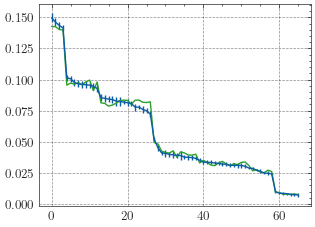

In [77]:
resampled = bootstrap(np.mean(calibration_expects, axis=1), reps=1000)
calibrate_means = np.mean(resampled, axis=(0,))
calibrate_stds = np.std(resampled, axis=(0,), ddof=1)
sort_idx = np.argsort(calibrate_means)[::-1]
plt.errorbar(np.arange(len(calibrate_means)), calibrate_means[sort_idx], yerr=calibrate_stds)
masks = np.array([np.array(list(x)) != 'I' for x in obs_strings])
pred = calculate_weight_v(masks, even_noise_values, odd_noise_values, 1)
plt.plot(pred[sort_idx], c='tab:green')

In [79]:
rng_key = jax.random.PRNGKey(1)

masks = jnp.array((np.array([list(x) for x in np.array(obs_strings)]) == obs_char).astype(int))
n_noise_terms = len(all_noise_keys)
process_noise_values = lambda x:jnp.log10(jnp.where(x == 0, 1e-5, x))

@jax.jit
def loss(x):
    even_lamb = 10**x[:n_noise_terms]
    odd_lamb = 10**x[n_noise_terms:]
    pred = calculate_weight_v(masks, even_lamb, odd_lamb, 1)
    return jnp.mean(((pred-calibrate_means)/calibrate_stds)**2)

X = process_noise_values(jnp.concatenate([even_noise_values, odd_noise_values], axis=0))
optimizer = optax.adam(learning_rate=3e-3)
opt_state = optimizer.init(X)

@jax.jit
def step(params, opt_state):
    loss_value, grads = jax.value_and_grad(loss)(params)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

losses = []
with trange(20000) as pbar:
    for i in pbar:
        X, opt_state, loss_value = step(X, opt_state)
        if i%20==0: 
            losses.append(loss_value)
            pbar.set_description("{:.2f}".format(loss_value))

  0%|          | 0/20000 [00:00<?, ?it/s]

(5.4197006, 10.695095)

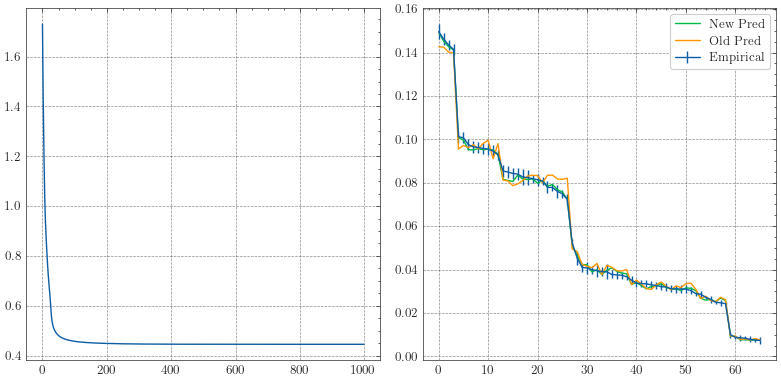

In [81]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.plot(losses)

plt.subplot(122)
plt.errorbar(np.arange(len(calibrate_means)), calibrate_means[sort_idx], yerr=calibrate_stds, label='Empirical')

new_preds = calculate_weight_v(masks, 10**X[:n_noise_terms], 10**X[n_noise_terms:], 1)
plt.plot(new_preds[sort_idx], c='C1', label='New Pred')
old_preds = calculate_weight_v(masks, even_noise_values, odd_noise_values, 1)
plt.plot(old_preds[sort_idx], c='C2', label='Old Pred')
plt.legend()
plt.tight_layout()
np.sqrt(np.sum(((new_preds-calibrate_means)/calibrate_stds)**2)), np.sqrt(np.sum(((old_preds-calibrate_means)/calibrate_stds)**2))

# Prob Inference

In [13]:
import numpyro
import numpyro.distributions as dist
import numpyro.distributions.constraints as constraints
from numpyro.handlers import lift

tn.set_default_backend("jax")
numpyro.set_host_device_count(2)
rng_key = jax.random.PRNGKey(0)
numpyro.enable_validation(True)
def model(mean_obs, std_obs, even_noise_values, odd_noise_values):
    even_mean = process_noise_values(even_noise_values)
    even_lamb = jnp.power(10, numpyro.sample('even_noise', dist.Normal(loc=even_mean, scale=2).expand([n_noise_terms])))

    odd_mean = process_noise_values(odd_noise_values)
    odd_lamb = jnp.power(10, numpyro.sample('odd_noise', dist.Normal(loc=odd_mean, scale=2).expand([n_noise_terms])))
    
    mean = calculate_weight_v(masks, even_lamb, odd_lamb)
    with numpyro.plate("N", len(mean_obs)):
        numpyro.sample("obs", dist.Normal(loc=mean, scale=std_obs), obs=mean_obs)

In [461]:
optimizer = numpyro.optim.Adam(step_size=2e-3)
guide = numpyro.infer.autoguide.AutoMultivariateNormal(model)
svi = numpyro.infer.SVI(model, guide, optimizer, loss=numpyro.infer.Trace_ELBO())
svi_result = svi.run(rng_key, 12000, mean_obs=calibrate_means, std_obs=calibrate_stds, 
                     even_noise_values=10**X[:n_noise_terms], odd_noise_values=10**X[n_noise_terms:])

100%|██████████████████████████████████████████████| 12000/12000 [00:51<00:00, 233.37it/s, init loss: 146562.8906, avg. loss [11401-12000]: 236.0079]


In [469]:
ev, od = jnp.split(10**svi_result.params['auto_loc'], 2)
ev

Array([6.54900703e-07, 9.69600864e-03, 1.35070313e-05, 9.91757770e-05,
       9.78462771e-03, 1.57210388e-06, 1.07026346e-04, 5.85300708e-03,
       1.70369050e-04, 7.83996802e-05, 3.54713649e-02, 7.53928725e-06,
       4.40798402e-02, 4.20741480e-06, 4.46900522e-05, 1.04789622e-03,
       2.20854957e-07, 3.70645919e-03, 5.23096770e-02, 5.20849484e-04,
       1.25373155e-01, 6.97331578e-02, 1.46034481e-05, 1.93782435e-05,
       1.75957226e-07, 5.65445796e-02, 1.08133047e-03, 6.51179434e-05,
       1.98961038e-06, 2.73539510e-04, 2.90015323e-05, 4.29091342e-05,
       2.30652904e-06, 1.13754359e-03, 1.71480895e-06, 5.28767705e-03,
       1.86916004e-05, 3.93544688e-05, 1.17071431e-06, 1.08695065e-03,
       7.49163255e-02, 6.36922632e-05, 3.47619206e-01, 3.21521424e-02,
       9.58048804e-06, 1.14211468e-06, 5.47671225e-03, 2.63718553e-02,
       1.53422402e-03, 2.99492586e-09, 7.89283513e-06, 7.04015690e-07,
       1.59247667e-02, 3.62474966e-04, 3.46272402e-02, 5.82186743e-10,
      

In [13]:
init = numpyro.infer.initialization.init_to_value(site=None,values={
    'even_noise': X[:n_noise_terms], 
    'odd_noise': X[n_noise_terms:]
})
kernel = numpyro.infer.NUTS(model, init_strategy=init, dense_mass=True, adapt_mass_matrix=True, inverse_mass_matrix=cov)
num_samples = 1000
mcmc = numpyro.infer.MCMC(kernel, num_warmup=400, num_samples=num_samples)
mcmc.run(rng_key, mean_obs=calibrate_means, std_obs=calibrate_stds, even_noise_values=10**X[:n_noise_terms], odd_noise_values=10**X[n_noise_terms:])

sample: 100%|█████████████████████████████████████| 1400/1400 [07:26<00:00,  3.13it/s, 1023 steps of size 6.95e-02. acc. prob=0.97]


In [14]:
mcmc.print_summary()


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
 even_noise[0]     -4.28      1.71     -4.18     -7.44     -1.80    608.45      1.00
 even_noise[1]     -6.53      2.02     -6.57     -9.89     -3.25    229.52      1.00
 even_noise[2]     -4.29      1.73     -4.16     -6.85     -1.32    578.39      1.00
 even_noise[3]     -2.95      1.48     -2.71     -5.14     -0.69    947.27      1.00
 even_noise[4]     -4.56      1.82     -4.48     -7.14     -1.40    145.44      1.01
 even_noise[5]     -4.12      1.74     -4.02     -6.55     -0.95    594.74      1.01
 even_noise[6]     -4.52      1.78     -4.45     -7.26     -1.75    632.10      1.00
 even_noise[7]     -2.87      1.40     -2.67     -4.79     -0.66    472.26      1.00
 even_noise[8]     -5.96      1.93     -5.90     -9.10     -2.82    478.34      1.00
 even_noise[9]     -5.11      1.81     -5.01     -8.16     -2.31    624.97      1.00
even_noise[10]     -2.97      1.38     -2.71     -5.07     -0.86

Text(0.5, 0.98, 'Noise parameters posterior (log space)')

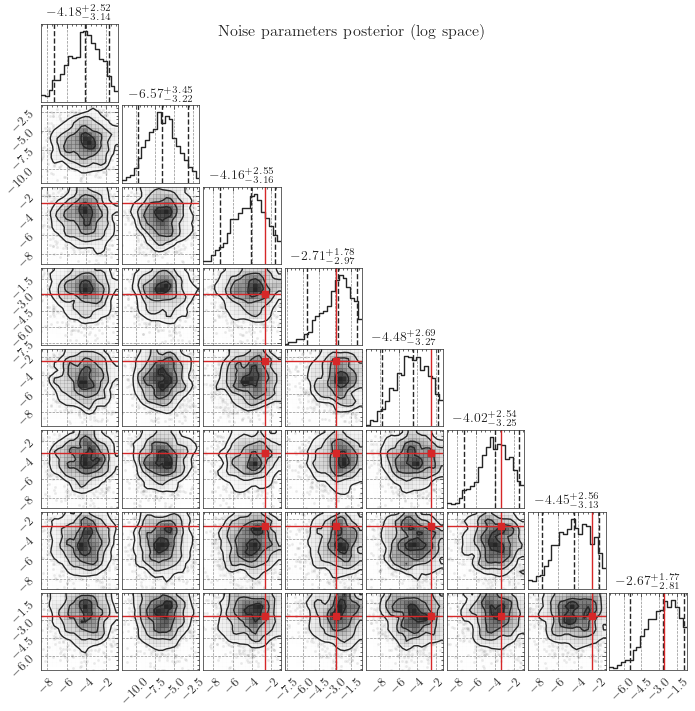

In [16]:
import corner
transformed_samples = mcmc.get_samples()
idxs = np.arange(0,8)
samples = (np.array(transformed_samples['even_noise'].tolist()))[:,idxs]
truths = jnp.log10(even_noise_values[idxs])
fig = plt.figure(figsize=(7,7))
corner.corner(samples,quantiles=[0.05, 0.5, 0.95],show_titles=True,truths=truths, truth_color='tab:red', fig=fig, smooth=1, smooth1d=0.5, range=[0.99 for _ in idxs]);
fig.suptitle('Noise parameters posterior (log space)')

In [17]:
inferred_noise_even = jnp.mean(10**transformed_samples['even_noise'], axis=(0,))
inferred_noise_odd = jnp.mean(10**transformed_samples['odd_noise'], axis=(0,))

(3.2246835, 5.2101393)

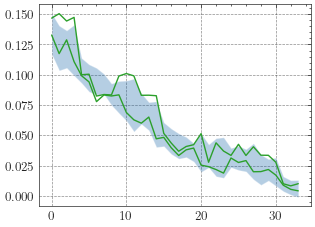

In [18]:
sort_idx = np.argsort(calibrate_means)[::-1]
plt.fill_between(np.arange(len(calibrate_means)), (calibrate_means-calibrate_stds)[sort_idx], (calibrate_means+calibrate_stds)[sort_idx], alpha=0.3)
masks = np.array([np.array(list(x)) != 'I' for x in obs_strings])
new_preds = calculate_weight_v(masks, inferred_noise_even, inferred_noise_odd)
plt.plot(new_preds[sort_idx], c='tab:green')
old_preds = calculate_weight_v(masks, even_noise_values, odd_noise_values)
plt.plot(old_preds[sort_idx], c='tab:green')
np.sqrt(np.sum(((new_preds-calibrate_means)/calibrate_stds)**2)), np.sqrt(np.sum(((old_preds-calibrate_means)/calibrate_stds)**2))

Text(0.5, 1.0, 'ZIIIIIIIII')

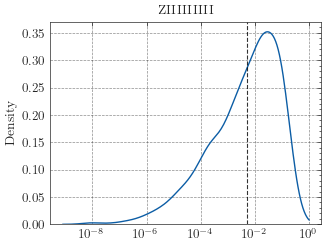

In [19]:
big_noise = jnp.mean(transformed_samples['even_noise'], axis=0) > -2.5
idx = np.argwhere(big_noise).flatten()[1]
sns.kdeplot(10**transformed_samples['even_noise'][:,idx], log_scale=True, clip=(None,0))
plt.axvline(even_noise_values[idx], c='black', ls='--', lw=0.8, alpha=0.8)
plt.title(noise_terms[idx])

# Inference

In [264]:
jax.config.update("jax_enable_x64", True)
inferred_noise_even = 10**X[:n_noise_terms].astype(jnp.float64)
inferred_noise_odd = 10**X[n_noise_terms:].astype(jnp.float64)

# inferred_noise_even = jnp.zeros_like(even_noise_values)
# inferred_noise_odd = jnp.zeros_like(odd_noise_values)

In [265]:
@jax.jit
def inverse_weight(mask, params):
    all_nodes = []
    shrinker = jnp.array([[1,0,0,0],
                          [0,1,1,1]]).T
    mask_to_p = jnp.array([[1.,0,0,0],[0,0,0,1]]) # pretend mask=1 means Z
    with tn.NodeCollection(all_nodes):
        weight_inv = [tn.Node(params[i]) for i in range(N)]
        for i in range(N):
            weight_inv[i][2] ^ weight_inv[(i+1)%N][1]

        left = [x[0] for x in weight_inv]
        end = [tn.Node(x) for x in mask_to_p[mask]]
        right = [x[0] for x in end]
        for i in range(N):
            apply_gate(right, shrinker, [i,])
            left[i] ^ right[i]
    result = tn.contractors.auto(all_nodes)
    return result.tensor
inverse_weight_v = jax.vmap(inverse_weight, (0,None))

In [266]:
rng_key = jax.random.PRNGKey(1)

p = jax.random.normal(rng_key, shape=(N,2,6,6)).astype(jnp.float64)/3

schedule = optax.warmup_cosine_decay_schedule(
  init_value=0.0,
  peak_value=2e-3,
  warmup_steps=500,
  decay_steps=20000,
  end_value=0.0,
)
optimizer = optax.adam(learning_rate=schedule)
opt_state = optimizer.init(p)
DEPTH = 1

zeros = jnp.zeros_like(inferred_noise_even)

@jax.jit
def loss(params, mask):
    a, b = inverse_weight_v(mask, params), calculate_weight_v(mask, inferred_noise_even, inferred_noise_odd, 1)
    return jnp.sum((a*b-1)**2)

@jax.jit
def step(params, opt_state, mask):
    loss_value, grads = jax.value_and_grad(loss)(params, mask)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

losses = []
bs = 1024
with trange(20000) as pbar:
    for i in pbar:
        rng_key, subkey = jax.random.split(rng_key)
        mask = jax.random.choice(key=subkey, a=2, shape=(bs,N))
        p, opt_state, loss_value = step(p, opt_state, mask)
        if i%20==0:
            losses.append(loss_value)
            pbar.set_description("{:.2f}".format(float(jnp.log10(loss_value))))

losses = jnp.array(losses)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [261]:
# import jax.scipy.optimize
# mask = jnp.array(list(itertools.product([0,1], repeat=N)))

# @jax.jit
# def loss(params):
#     a, b = inverse_weight_v(mask, params.reshape((N,2,8,8))), calculate_weight_v(mask, inferred_noise_even, inferred_noise_odd)
#     return jnp.mean((a*b-1)**2)

# ret = jax.scipy.optimize.minimize(loss, x0=p.flatten(), method='BFGS')
# p = ret.x.reshape((N,2,8,8))

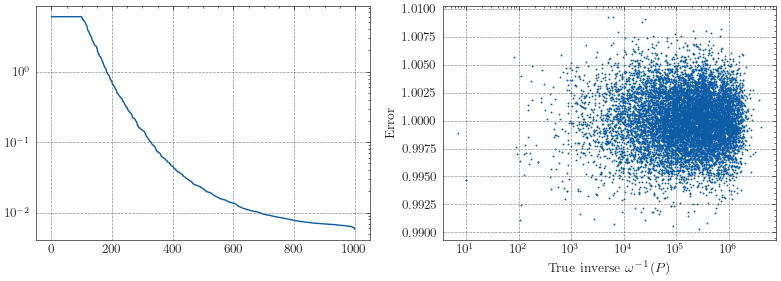

In [311]:
import scipy.signal
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8,3))
p = np.load('cluster_18_20231221/results/p-noisy-d1.npy').reshape((N,2,6,6))
ax0.semilogy(scipy.signal.medfilt(np.array(losses), 201))
# ax0.set_ylim(None, 1)
all_masks = jax.random.choice(key=rng_key, a=2, shape=(10000,N))
truth = 1/calculate_weight_v(all_masks, inferred_noise_even, inferred_noise_odd,1)
pred = inverse_weight_v(all_masks, p)
ax1.scatter(truth, pred/truth, s=0.3)
ax1.set_xscale('log')
ax1.set_xlabel(r'True inverse $\omega^{-1}(P)$')
ax1.set_ylabel(r'Error')
fig.tight_layout()
# np.save('./cluster_18_20231221/p-noisy-d1.npy', p)

# Fidelity

In [342]:
with open('./cluster_18_20231221/20231221_result_cluster_18_d_1.pkl', 'rb') as f:
    dat = [{k[::-1]: v for k, v in d.items()} for d in pickle.load(f)]

In [343]:
def tensor(lst):
    ret = lst[0]
    for x in lst[1:]: ret = ret.tensor(x)
    return ret
pauli_dict = {i+j: qi.Pauli(i+j).to_matrix() for i in ['I','X','Y','Z'] for j in ['I','X','Y','Z']}
pauli_dict['I'] = qi.Pauli('I').to_matrix()
pauli_dict['X'] = qi.Pauli('X').to_matrix()
pauli_dict['Y'] = qi.Pauli('Y').to_matrix()
pauli_dict['Z'] = qi.Pauli('Z').to_matrix()

In [344]:
SWAP = np.array([
    [1,0,0,0],
    [0,0,1,0],
    [0,1,0,0],
    [0,0,0,1]
])
def get_ptm(U, swap=False):
    num_q = U.num_qubits
    if isinstance(U, qi.operators.symplectic.clifford.Clifford) and num_q == 1:
        return cliff_ptm_dict[tuple(U.to_labels())]
    M = U.to_matrix()
    ret = None
    if num_q == 2:
        if swap: M = SWAP @ M @ SWAP
        ret = np.zeros((4,4,4,4))
        for i in range(4):
            for j in range(4):
                inp = pauli_dict[paulis[i]+paulis[j]]
                for k in range(4):
                    for l in range(4):
                        out = pauli_dict[paulis[k]+paulis[l]]
                        ret[i,j,k,l] = np.real(np.einsum('ij,ji->', out, M @ inp @ np.conj(M.T)))/4
    else:
        ret = np.zeros((4,4))
        for i in range(4):
            for j in range(4):
                ret[i,j] = np.real(np.einsum('ij,ji->', pauli_dict[paulis[j]], M @ pauli_dict[paulis[i]] @ np.conj(M.T)))/2
    return ret.round(15)

CNOT = qi.Operator(np.array([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,0,1],
    [0,0,1,0]
]))
CNOT_ptm = get_ptm(CNOT)

In [345]:
import qiskit.qpy
from qiskit.transpiler.passes import RemoveBarriers

cluster_qc = qiskit.QuantumCircuit(N)
for i in range(N):
    cluster_qc.h(i)
for i in range(0,N,2):
    cluster_qc.cz(i,i+1)
for i in range(1,N-1,2):
    cluster_qc.cz(i,i+1)
prep_circ = [(get_ptm(gate.operation, swap=True), [q.index for q in gate.qubits]) for gate in cluster_qc.data if gate.operation.name != 'barrier']
cluster_qc.draw()

/var/folders/sw/mqhrfvw123bbsf3rnj779gj40000gn/T/ipykernel_22073/3948907623.py:11: DeprecationWarning: 'Bit.index' is deprecated since Qiskit Terra 0.17 and will be removed in a future release. Bits may be in more than one register. Use 'QuantumCircuit.find_bit' to find all the containing registers within a circuit, and the index of the bit within the circuit.
  prep_circ = [(get_ptm(gate.operation, swap=True), [q.index for q in gate.qubits]) for gate in cluster_qc.data if gate.operation.name != 'barrier']


┌───┐      
 q_0: ┤ H ├─■────
      ├───┤ │    
 q_1: ┤ H ├─■──■─
      ├───┤    │ 
 q_2: ┤ H ├─■──■─
      ├───┤ │    
 q_3: ┤ H ├─■──■─
      ├───┤    │ 
 q_4: ┤ H ├─■──■─
      ├───┤ │    
 q_5: ┤ H ├─■──■─
      ├───┤    │ 
 q_6: ┤ H ├─■──■─
      ├───┤ │    
 q_7: ┤ H ├─■──■─
      ├───┤    │ 
 q_8: ┤ H ├─■──■─
      ├───┤ │    
 q_9: ┤ H ├─■──■─
      ├───┤    │ 
q_10: ┤ H ├─■──■─
      ├───┤ │    
q_11: ┤ H ├─■──■─
      ├───┤    │ 
q_12: ┤ H ├─■──■─
      ├───┤ │    
q_13: ┤ H ├─■──■─
      ├───┤    │ 
q_14: ┤ H ├─■──■─
      ├───┤ │    
q_15: ┤ H ├─■──■─
      ├───┤    │ 
q_16: ┤ H ├─■──■─
      ├───┤ │    
q_17: ┤ H ├─■────
      └───┘

In [365]:
delta3 = np.zeros((4,4,4))
for i in range(4):
    delta3[i,i,i] = 1.0
delta3 = jnp.array(delta3)
shrinker = jnp.array([[1,0,0,0], [0,1,1,1]])
@ft.partial(jax.jit)
def estimate_fid(shadow, twirl_circ, p):
    all_nodes = []
    N = len(shadow)
    
    with tn.NodeCollection(all_nodes):
        weight_inv = [tn.Node(p[i]) for i in range(N)]
        weight_inv_out = [x[0] for x in weight_inv]
        for i in range(N):
            weight_inv[i][2] ^ weight_inv[(i+1)%N][1]
            apply_gate(weight_inv_out, shrinker, [i,])
        tmp = [tn.Node(jnp.array([1/2,0,0,1/2])) for i in range(N)]
        target = [x[0] for x in tmp]
        for (ptm, sites) in prep_circ:
            apply_gate(target, ptm, sites)
        gs = [tn.Node(delta3) for _ in range(N)]
        for i in range(N):
            gs[i][0] ^ weight_inv_out[i]
            gs[i][1] ^ target[i]
            
        tmp2 = [tn.Node(jnp.array([1.,0,0,(-1)**b])) for b in shadow]
        sh = [x[0] for x in tmp2]
        for i in range(N):
            apply_gate(sh, cliff_ptm_arr[twirl_circ[-1,i]].T, (i,))
        if twirl_circ.shape[0] > 1:
            for LAYER in range(2, twirl_circ.shape[0]+1, 2):
                for i in range(1, N-1, 2):
                    apply_gate(sh, CNOT_ptm, (i,i+1))
                for i in range(N):
                    apply_gate(sh, cliff_ptm_arr[twirl_circ[-LAYER,i]].T, (i,))
                for i in range(0, N, 2):
                    apply_gate(sh, CNOT_ptm, (i,i+1))
                for i in range(N):
                    apply_gate(sh, cliff_ptm_arr[twirl_circ[-LAYER-1,i]].T, (i,))
        
        for i in range(N):
            gs[i][2] ^ sh[i]
    # return tn.visualization.graphviz.to_graphviz(all_nodes)
    result = tn.contractors.auto(all_nodes)
    return result.tensor
estimate_fid_v = jax.vmap(estimate_fid, (0, None, None))

In [347]:
@ft.partial(jax.jit)
def estimate_obs(shadow, twirl_circ, p, obs):
    all_nodes = []
    N = len(shadow)

    with tn.NodeCollection(all_nodes):
        weight_inv = [tn.Node(p[i]) for i in range(N)]
        weight_inv_out = [x[0] for x in weight_inv]
        for i in range(N):
            weight_inv[i][2] ^ weight_inv[(i+1)%N][1]
            apply_gate(weight_inv_out, shrinker, [i,])

        tmp = [tn.Node(obs[i]) for i in range(N)]
        target = [x[0] for x in tmp]
        
        gs = [tn.Node(delta3) for _ in range(N)]
        for i in range(N):
            gs[i][0] ^ weight_inv_out[i]
            gs[i][1] ^ target[i]

        tmp2 = [tn.Node(jnp.array([1.,0,0,(-1)**b])) for b in shadow]
        sh = [x[0] for x in tmp2]
        for i in range(N):
            apply_gate(sh, cliff_ptm_arr[twirl_circ[-1,i]].T, (i,))
        if twirl_circ.shape[0] > 1:
            for LAYER in range(2, twirl_circ.shape[0]+1, 2):
                for i in range(1, N-1, 2):
                    apply_gate(sh, CNOT_ptm, (i,i+1))
                for i in range(N):
                    apply_gate(sh, cliff_ptm_arr[twirl_circ[-LAYER,i]].T, (i,))
                for i in range(0, N, 2):
                    apply_gate(sh, CNOT_ptm, (i,i+1))
                for i in range(N):
                    apply_gate(sh, cliff_ptm_arr[twirl_circ[-LAYER-1,i]].T, (i,))

        for i in range(N):
            gs[i][2] ^ sh[i]
    # return tn.visualization.graphviz.to_graphviz(all_nodes)
    result = tn.contractors.auto(all_nodes)
    return result.tensor
estimate_obs_v = jax.vmap(jax.vmap(estimate_obs, (0, None, None, None)), (None,None,None,0))

In [348]:
# string_operators = ['X'*i+'I'*(N-i) for i in range(1, N+1)]
string_operators = [
    "ZXZIIIIIIIIIIIIIII",
    "ZYYZIIIIIIIIIIIIII",
    "ZYXYZIIIIIIIIIIIII",
    "ZYXXYZIIIIIIIIIIII",
    "ZYXXXYZIIIIIIIIIII",
    "ZYXXXXYZIIIIIIIIII", 
    "ZYXXXXXYZIIIIIIIII", 
    "ZYXXXXXXYZIIIIIIII", 
    "ZYXXXXXXXYZIIIIIII", 
    "ZYXXXXXXXXYZIIIIII", 
    "ZYXXXXXXXXXYZIIIII", 
    "ZYXXXXXXXXXXYZIIII", 
    "ZYXXXXXXXXXXXYZIII", 
    "ZYXXXXXXXXXXXXYZII", 
    "ZYXXXXXXXXXXXXXYZI", 
    "ZYXXXXXXXXXXXXXXYZ"
]
p_to_idx = ['I','X','Y','Z']

string_obs = jnp.array([[np.eye(4)[p_to_idx.index(char)] for char in str(qi.Pauli(x))] for x in string_operators][1::2])

In [349]:
shadow_mean_no_mit = []
p = np.load('cluster_18_20231221/results/p-no-noise-d1.npy').reshape((N,2,6,6))
with trange(len(circs)) as pbar:
    for i in pbar:
        keys = list(dat[i].keys())
        shadows = jnp.array([jnp.array(np.array(list(k)).astype(int)) for k in keys])
        counts = jnp.array([dat[i][k] for k in keys])
        tmp = []
        for j in range(len(shadows)):
            tmp.extend([shadows[j] for _ in range(counts[j])])
        shadows = jnp.array(tmp)
        values = estimate_obs_v(shadows, circ_to_cliffs(circs[i]), p, string_obs)
        shadow_mean_no_mit.append(values)
        if i % 10 == 0: 
            mean,std = calc_mean(np.array(shadow_mean_no_mit))
            pbar.set_description(f'{mean:.3f} ± {std:.3f}')

  0%|          | 0/10000 [00:00<?, ?it/s]

/var/folders/sw/mqhrfvw123bbsf3rnj779gj40000gn/T/ipykernel_22073/484017899.py:24: DeprecationWarning: 'Bit.index' is deprecated since Qiskit Terra 0.17 and will be removed in a future release. Bits may be in more than one register. Use 'QuantumCircuit.find_bit' to find all the containing registers within a circuit, and the index of the bit within the circuit.
  site = g.qubits[0].index


In [350]:
np.savez_compressed('cluster_18_20231221/results/obs-cluster-d1-no-mitigate', np.array(shadow_mean_no_mit))

In [94]:
def bootstrap(data, reps=10):
    ret = []
    data = np.array(data)
    for rep in trange(reps):
        circ_idxs = np.random.choice(10000, size=(10000,), replace=True)
        ret.append(np.mean(data[circ_idxs]))
    return np.array(ret)

# D=0

In [351]:
with open('./cluster_18_20231221/20231221_clifford_circ_cluster_18_listd_d_0.pkl', 'rb') as f:
    circs_d0 = [x.remove_final_measurements(inplace=False) for x in pickle.load(f)]

with open('./cluster_18_20231221/20231221_result_cali_18_d_0.pkl', 'rb') as f:
    dat_d0 = [{k[::-1]: v for k, v in d.items()} for d in pickle.load(f)]

In [352]:
CNOT_pyc = pyc.stabilizer.CliffordMap(np.array([
    [1,0,1,0],
    [0,1,0,0],
    [0,0,1,0],
    [0,1,0,1]
]), np.zeros(4))

def circ_to_pyc(circ):
    U = pyc.stabilizer.identity_map(N)
    cliff_idxs = circ_to_cliffs(circ)
    offset = 1
    for d in range(len(cliff_idxs)):
        Utmp = pyc.stabilizer.identity_map(N)
        for i in range(N):
            op = cliffs[cliff_idxs[-(d+1),i]] # go backwards
            twirl = pyc.stabilizer.CliffordMap(op.tableau[:,:-1], 2*op.tableau[:,-1])
            mask = np.zeros(N)
            mask[i] = 1
            Utmp.embed(twirl, mask.astype(bool))
        U = U.compose(Utmp)
    return U


def get_shadow(idx, observables):
    U = circ_to_pyc(circs_d0[idx])
    gs = pyc.stabilizer.zero_state(N).gs
    ret = []
    for bitstring in dat_d0[idx].keys():
        count = dat_d0[idx][bitstring]
        bitstring = np.array(list(bitstring)).astype(int)
        state = pyc.stabilizer.StabilizerState(gs=gs, ps=2*np.stack([bitstring, np.zeros(N)]).flatten())
        state = state.transform_by(U)
        ret.extend([state.expect(observables)]*count)
    return np.array(ret)

obs_char = 'Z'
obs_strings = [''.join(np.roll([obs_char]+['I']*(N-1),d)) for d in range(N)]
obs_strings += [''.join(np.roll([obs_char]*2+['I']*(N-2),d)) for d in range(N)]
obs_strings += [''.join(np.roll([obs_char]*3+['I']*(N-3),d)) for d in range(N)]
# obs_strings += [''.join(np.roll([obs_char]*4+['I']*(N-4),d)) for d in range(N)]
obs = pyc.paulialg.paulis(obs_strings)
calibration_expects = np.array([get_shadow(i, obs) for i in trange(len(circs_d0))])

  0%|          | 0/10000 [00:00<?, ?it/s]

/var/folders/sw/mqhrfvw123bbsf3rnj779gj40000gn/T/ipykernel_22073/484017899.py:24: DeprecationWarning: 'Bit.index' is deprecated since Qiskit Terra 0.17 and will be removed in a future release. Bits may be in more than one register. Use 'QuantumCircuit.find_bit' to find all the containing registers within a circuit, and the index of the bit within the circuit.
  site = g.qubits[0].index


In [353]:
mask = np.array([np.array(list(x)) == 'Z' for x in obs_strings]).astype(np.float32)
calibrate_mean = np.mean(calibration_expects, axis=(0,1))
calibrate_std = np.std(calibration_expects, axis=(0,1))
ret = scipy.optimize.minimize(lambda x: np.mean(((3**(-mask@x) - calibrate_mean)/calibrate_std)**2), x0=np.ones(N), 
                              bounds=([(1,None) for _ in range(N)]))

In [366]:
with open('./cluster_18_20231221/20231221_result_cluster_18_d_0.pkl', 'rb') as f:
    dat_d0 = [{k[::-1]: v for k, v in d.items()} for d in pickle.load(f)]
calibrated = 1/np.mean(calibration_expects, axis=(0,1))
shadow_mean_d0 = []
# p2 = jnp.ones((N,2,1,1)).astype(jnp.float64).at[:,1].set((3**ret.x)[:,None,None])
p2 = jnp.ones((N,2,1,1)).astype(jnp.float64).at[:,1].set(3.)
with trange(len(circs)) as pbar:
    for i in pbar:
        keys = list(dat_d0[i].keys())
        shadows = jnp.array([jnp.array(np.array(list(k)).astype(int)) for k in keys])
        counts = jnp.array([dat_d0[i][k] for k in keys])
        tmp = []
        for j in range(len(shadows)):
            tmp.extend([shadows[j] for _ in range(counts[j])])
        shadows = jnp.array(tmp)
        values = estimate_fid_v(shadows, circ_to_cliffs(circs_d0[i]), p2)
        shadow_mean_d0.append(values)
        if i % 10 == 0: 
            mean,std = calc_mean(np.array(shadow_mean_d0))
            pbar.set_description(f'{mean:.3f} ± {std:.3f}')

  0%|          | 0/10000 [00:00<?, ?it/s]

/var/folders/sw/mqhrfvw123bbsf3rnj779gj40000gn/T/ipykernel_22073/484017899.py:24: DeprecationWarning: 'Bit.index' is deprecated since Qiskit Terra 0.17 and will be removed in a future release. Bits may be in more than one register. Use 'QuantumCircuit.find_bit' to find all the containing registers within a circuit, and the index of the bit within the circuit.
  site = g.qubits[0].index


In [367]:
np.save('cluster_18_20231221/results/fidelity-cluster-d0-no-mitigate.npy', np.array(shadow_mean_d0))

In [56]:
with open("cluster_18_20231221/20231221_result_cluster_18q_string.pkl", "rb") as f:
    tmp = pickle.load(f)

st_to_arr = lambda x: np.where(np.array(list(x[::-1])).astype(int), -1, 1)
for idx in range(len(tmp)):
    blah = np.array([np.prod(st_to_arr(k)[:idx+3])*v for k,v in tmp[idx].items()])
    print(np.sum(blah)/10000)

0.9192
0.862
-0.8336
0.7926
-0.7986
0.7684
-0.7588
0.7492
-0.7104
0.6916
-0.6732
0.645
-0.6098
0.5788
-0.5656
0.559
